# Interpretability

In [1]:

import os
import sys
import getopt
import copy
import shutil
import json
from importlib import util
from functools import partial

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchaudio

import tensorkrowch as tk
from tensorkrowch.decompositions.tt_rss import tt_rss

import captum as cp

import matplotlib.pyplot as plt

In [2]:
# torch.set_num_threads(1)

cwd = os.getcwd()
p_indian_list = [0.005, 0.01, 0.05,
                 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9,
                 0.95, 0.99, 0.995]
out_rate = 1000

## Load Datasets

In [3]:
class CustomCommonVoice(Dataset):
    """
    Class for the (imbalanced) datasets created.

    Parameters
    ----------
    p_indian : float (p_indian_list)
        Proportion of audios of people with indian accent in the dataset.
    idx : int [0, 9]
        Index of the annotations to be used. For each ``p_indian`` there are 10
        datasets.
    set : {"train", "val", "test"}
        Indicates which dataset is to be loaded.
    transform : torchvision.transforms
        Transformations of the dataset (data augmentation, normalization, etc.)
    target_transform : func
        Transformation of the target attribute (not used).
    """
    
    def __init__(self,
                 p_indian,
                 idx,
                 set="train_df.tsv",
                 transform=None):
        
        global p_indian_list
        if (p_indian not in p_indian_list) or ((idx < 0) or (idx > 9)):
            raise ValueError(
                f'`p_indian` can only take values within {p_indian_list}, '
                f'and `idx` should be between 0 and 9')
        
        global cwd
        self.dataset = torchaudio.datasets.COMMONVOICE(
            root=os.path.join(cwd, 'CommonVoice'),
            tsv=os.path.join('datasets', str(p_indian), str(idx), set))
        self.transform = transform

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        x, y, z = self.dataset[index]
        if self.transform:
            x = self.transform((x, y))
        return x, int(z['sex'])

In [4]:
def resample(x):
    global out_rate
    x, in_rate = x
    resample_trans = torchaudio.transforms.Resample(in_rate, out_rate)
    return resample_trans(x)

def crop(x):
    global out_rate
    llimit = (x.size(1) // 2 - out_rate // 2)
    rlimit = (x.size(1) // 2 + out_rate // 2)
    x = x[:, llimit:rlimit].flatten()
    if x.size(0) < out_rate:
        return None
    return x

def rfft(x):
    if x is None:
        return None
    return torch.fft.rfft(x)[:-1].abs()

def normalize(x):
    x = x / 200
    x = torch.where(x <= 0, 1e-5, x)
    x = torch.where(x >= 1, 1 - 1e-5, x)
    return x

transform = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(resample),
    torchvision.transforms.Lambda(crop),
    torchvision.transforms.Lambda(rfft),
    torchvision.transforms.Lambda(normalize)
    ])

def none_collate(batch):
    batch = list(filter(lambda x: x[0] is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

In [5]:
def load_data(p_indian, idx, batch_size):
    """Loads dataset performing the required transformations for train or test."""
    
    # Load datasets
    global transform
    train_dataset = CustomCommonVoice(p_indian,
                                      idx,
                                      set="train_df.tsv",
                                      transform=transform)
    val_dataset = CustomCommonVoice(p_indian,
                                    idx,
                                    set="val_df.tsv",
                                    transform=transform)
    test_dataset = CustomCommonVoice(p_indian,
                                     idx,
                                     set="test_df.tsv",
                                     transform=transform)
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              collate_fn=none_collate,
                              shuffle=True)
    val_loader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            collate_fn=none_collate,
                            shuffle=False)
    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             collate_fn=none_collate,
                             shuffle=False)
    
    return train_loader, val_loader, test_loader

In [6]:
def load_sketch_samples(p_indian, idx, batch_size):
    """Loads sketch samples to tensorize models."""
    
    # Load datasets
    global transform
    test_tensorize_dataset = CustomCommonVoice(p_indian,
                                               idx,
                                               set="test_df_tensorize.tsv",
                                               transform=transform)
    test_unused_dataset = CustomCommonVoice(p_indian,
                                            idx,
                                            set="test_df_unused.tsv",
                                            transform=transform)
    
    # Create DataLoaders
    test_tensorize_loader = DataLoader(test_tensorize_dataset,
                                       batch_size=500,
                                       collate_fn=none_collate,
                                       shuffle=False)
    test_unused_loader = DataLoader(test_unused_dataset,
                                    batch_size=batch_size,
                                    collate_fn=none_collate,
                                    shuffle=False)
    
    return test_tensorize_loader, test_unused_loader

## Load models

In [7]:
def import_file(full_name, path):
    """Returns a python module given its path"""
    spec = util.spec_from_file_location(full_name, path)
    mod = util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    return mod

In [8]:
interpretability_results_dir = os.path.join(cwd, 'results', 'interpretability')
interpretability_results = os.listdir(interpretability_results_dir)
    
model_names = ['fffc_tiny']
models = []

for name in model_names:
    # Load model class
    file = import_file('model', os.path.join(cwd, 'models', f'{name}.py'))
    model_class = file.Model
    
    # Load config
    results_dir = os.path.join(cwd, 'results', model_class.name, '0.5')
    with open(os.path.join(results_dir, 'tuned_config.json'), 'r') as f:
        config = json.load(f)
    
    # Load state_dict
    state_dict_dir = list(filter(lambda f: f.startswith(name),
                                 interpretability_results))[0]
    state_dict = torch.load(os.path.join(interpretability_results_dir,
                                         state_dict_dir))
    
    # Instantiate model
    model = model_class(config)
    model.load_state_dict(state_dict)
    model.eval()
    
    models.append(model)

In [9]:
[m.name for m in models]

['fffc_tiny']

## Check accuracies

In [82]:
def test(device, model, test_loader, batch_size):
    """Computes accuracy on test set."""
    running_acc = 0
    
    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)
            
            scores = model(data)
            _, preds = torch.max(scores, 1)
            
            with torch.no_grad():
                accuracy = torch.sum(preds == labels).item() / batch_size
                running_acc += accuracy
    
    return running_acc / len(test_loader)

In [83]:
p_indian = 0.5
idx = 0
batch_size = 500

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

_, _, test_loader = load_data(p_indian, idx, batch_size)

In [84]:
model_accuracies = []

for model in models:
    test_acc = test(device, model.to(device), test_loader, batch_size)
    print(model.name, test_acc)
    
    model_accuracies.append(test_acc)

fffc_tiny 0.89545


## Interpret NN

In [18]:
p_indian = 0.5
idx = 0
batch_size = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

_, _, test_loader = load_data(p_indian, idx, batch_size)

samples, labels = next(iter(test_loader))
samples.shape

torch.Size([100, 500])

In [19]:
labels

tensor([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        1, 0, 0, 1])

In [20]:
sample = samples[4]

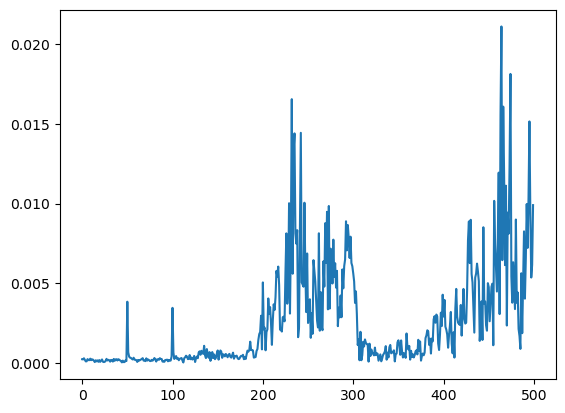

In [21]:
plt.plot(sample)
plt.show()

### Layer-wise Relevance Propagation

In [25]:
model = models[0].to(device)
model_lrp = cp.attr.LRP(model)

relevance0 = model_lrp.attribute(sample.unsqueeze(0).to(device),
                                 target=0).detach().cpu()[0]
relevance1 = model_lrp.attribute(sample.unsqueeze(0).to(device),
                                 target=1).detach().cpu()[0]

/home/jose/anaconda3/envs/obfuscation/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [30]:
model(sample.unsqueeze(0).to(device)).shape

torch.Size([1, 2])

In [26]:
softmax = nn.Softmax(dim=1)

softmax(model(sample.unsqueeze(0).to(device)))

tensor([[0.9805, 0.0195]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [27]:
model(sample.unsqueeze(0).to(device)), model(sample.unsqueeze(0).to(device)).shape

(tensor([[ 1.9714, -1.9467]], device='cuda:0', grad_fn=<AddmmBackward0>),
 torch.Size([1, 2]))

In [28]:
relevance0.sum(), relevance1.sum()

(tensor(2.2068), tensor(-2.2295))

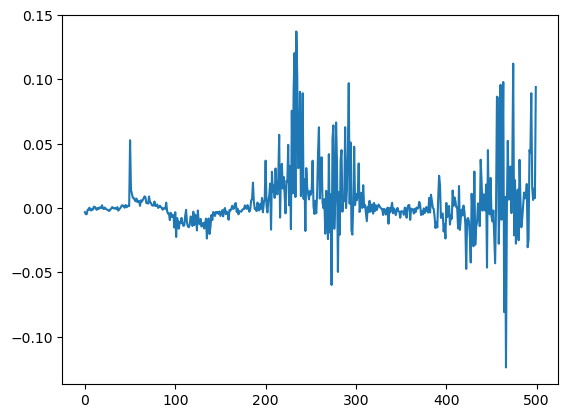

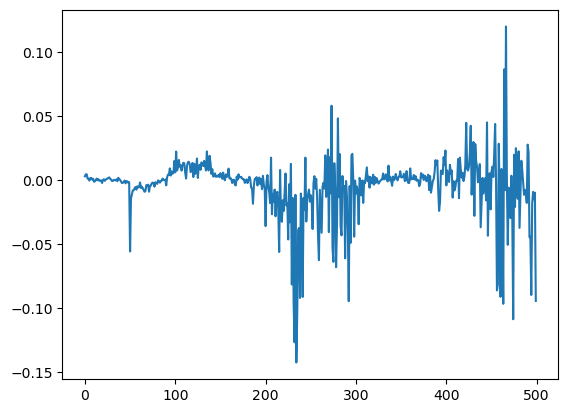

In [29]:
plt.plot(relevance0)
plt.show()

plt.plot(relevance1)
plt.show()

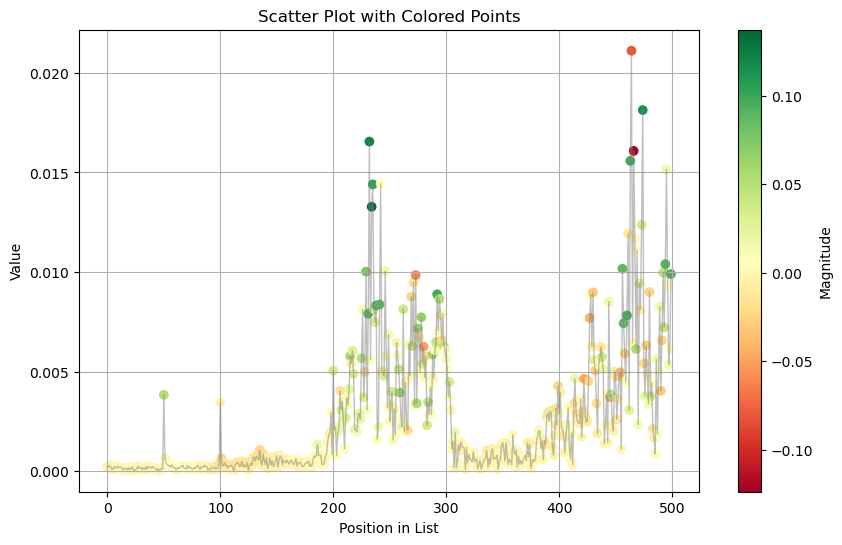

In [28]:
points = sample
values = relevance0

# Normalize the values for the color map
norm = plt.Normalize(values.min(), values.max())

# Create a colormap that goes from red to green
cmap = plt.cm.RdYlGn

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.plot(list(range(500)), points, color='grey', alpha=0.5, linewidth=1)
scatter = plt.scatter(list(range(500)), points, c=values, cmap=cmap, norm=norm)
plt.colorbar(scatter, label='Magnitude')  # Add colorbar to show the mapping
plt.title('Scatter Plot with Colored Points')
plt.xlabel('Position in List')
plt.ylabel('Value')
plt.grid(True)
plt.show()

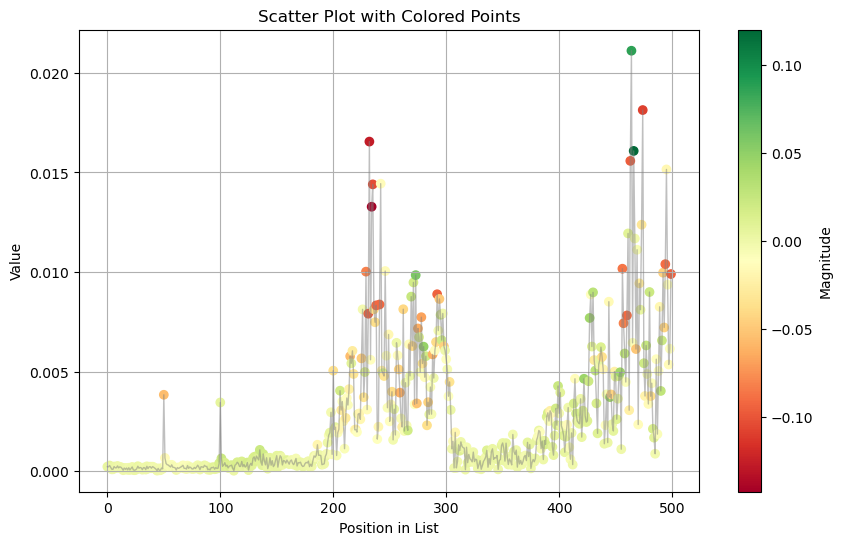

In [29]:
points = sample
values = relevance1

# Normalize the values for the color map
norm = plt.Normalize(values.min(), values.max())

# Create a colormap that goes from red to green
cmap = plt.cm.RdYlGn

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.plot(list(range(500)), points, color='grey', alpha=0.5, linewidth=1)
scatter = plt.scatter(list(range(500)), points, c=values, cmap=cmap, norm=norm)
plt.colorbar(scatter, label='Magnitude')  # Add colorbar to show the mapping
plt.title('Scatter Plot with Colored Points')
plt.xlabel('Position in List')
plt.ylabel('Value')
plt.grid(True)
plt.show()

### Integrated Gradients

In [31]:
model = models[0].to(device)
model_lrp = cp.attr.IntegratedGradients(model)

igradients0 = model_lrp.attribute(sample.unsqueeze(0).to(device),
                                  torch.zeros(1, 500, device=device),
                                  0).detach().cpu()[0]
igradients1 = model_lrp.attribute(sample.unsqueeze(0).to(device),
                                  torch.zeros(1, 500, device=device),
                                  1).detach().cpu()[0]

In [32]:
softmax = nn.Softmax(dim=1)

softmax(model(sample.unsqueeze(0).to(device)))

tensor([[0.9805, 0.0195]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [33]:
model(sample.unsqueeze(0).to(device))

tensor([[ 1.9714, -1.9467]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [34]:
igradients0.sum(), igradients1.sum()

(tensor(1.5978, dtype=torch.float64), tensor(-1.6215, dtype=torch.float64))

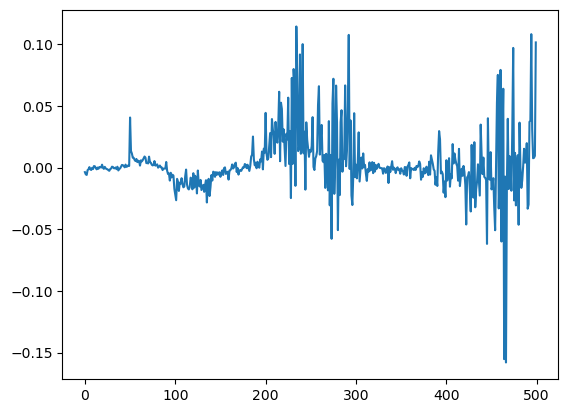

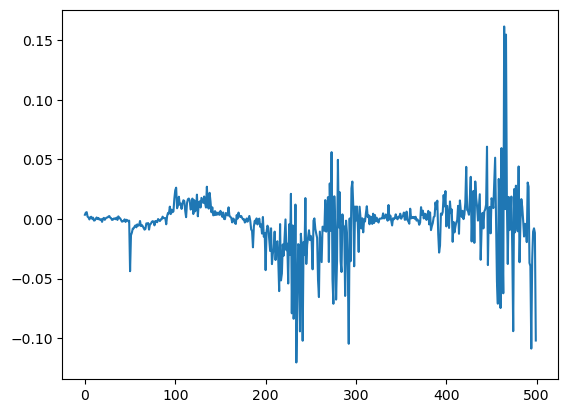

In [35]:
plt.plot(igradients0)
plt.show()

plt.plot(igradients1)
plt.show()

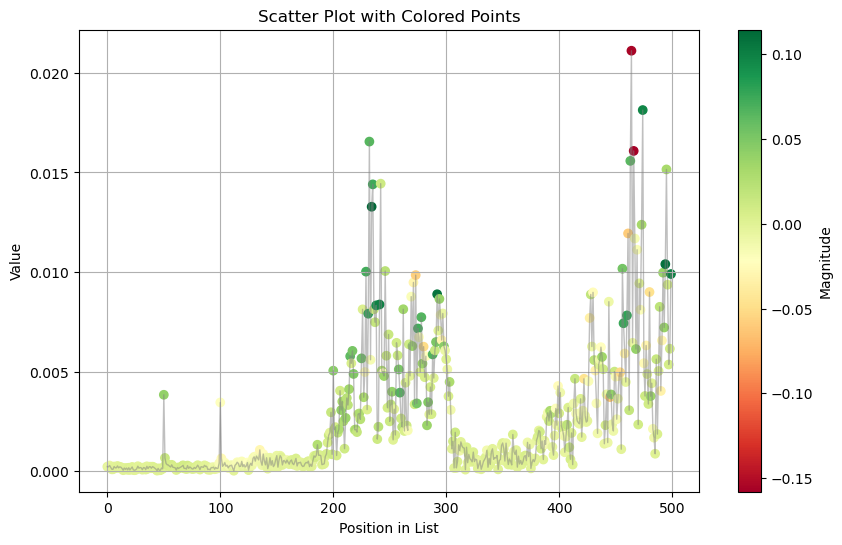

In [36]:
points = sample
values = igradients0

# Normalize the values for the color map
norm = plt.Normalize(values.min(), values.max())

# Create a colormap that goes from red to green
cmap = plt.cm.RdYlGn

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.plot(list(range(500)), points, color='grey', alpha=0.5, linewidth=1)
scatter = plt.scatter(list(range(500)), points, c=values, cmap=cmap, norm=norm)
plt.colorbar(scatter, label='Magnitude')  # Add colorbar to show the mapping
plt.title('Scatter Plot with Colored Points')
plt.xlabel('Position in List')
plt.ylabel('Value')
plt.grid(True)
plt.show()

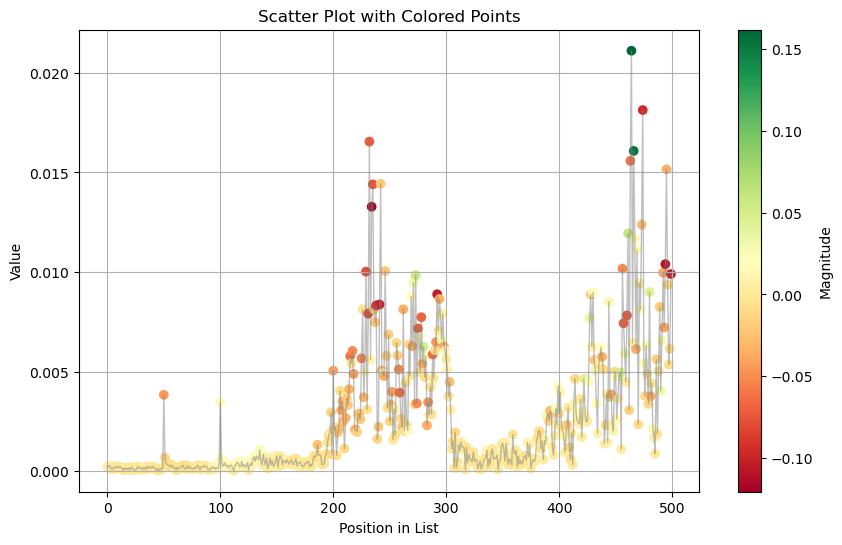

In [37]:
points = sample
values = igradients1

# Normalize the values for the color map
norm = plt.Normalize(values.min(), values.max())

# Create a colormap that goes from red to green
cmap = plt.cm.RdYlGn

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.plot(list(range(500)), points, color='grey', alpha=0.5, linewidth=1)
scatter = plt.scatter(list(range(500)), points, c=values, cmap=cmap, norm=norm)
plt.colorbar(scatter, label='Magnitude')  # Add colorbar to show the mapping
plt.title('Scatter Plot with Colored Points')
plt.xlabel('Position in List')
plt.ylabel('Value')
plt.grid(True)
plt.show()

## Load TN models

In [10]:
p_indian = 0.5
idx = 0
batch_size = 500

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tensorize_loader, _ = load_sketch_samples(p_indian, idx, batch_size)

sketch_samples = next(iter(tensorize_loader))[0]
sketch_samples.shape

torch.Size([500, 500])

In [11]:
num_classes = 2
n_features = sketch_samples.shape[1] + 1

phys_dim = 2
# bond_dim = 5
cum_percentage = 0.95
domain_multiplier = 2

domain = torch.arange(domain_multiplier * phys_dim).float() / \
    (domain_multiplier * phys_dim)
labels = torch.randint(low=0, high=num_classes, size=(sketch_samples.shape[0],))

n_samples = 250
batch_size = 1000


def embedding(x):
    x = tk.embeddings.poly(x, degree=phys_dim - 1)
    return x

# def embedding(x):
#     x = torch.stack([x, 1 - x], dim=-1)
#     return x

# def embedding(x):
#     x = tk.embeddings.unit(x, dim=phys_dim)
#     return x

# def embedding(x):
#     x = tk.embeddings.discretize(x, base=phys_dim, level=1).squeeze(-1).int()
#     x = tk.embeddings.basis(x, dim=phys_dim).float() # batch x n_features x dim
#     return x

# def embedding(x):
#     x = tk.embeddings.basis(x, dim=phys_dim).float()
#     return x

In [12]:
interpretability_results_dir = os.path.join(cwd, 'results', 'interpretability')
interpretability_results = os.listdir(interpretability_results_dir)
    
model_names = ['fffc_tiny']
tn_models = []

for name in model_names:
    aux_tn_models = []
    for bond_dim in [2, 5, 10]:
        # Load cores
        cores_dir = list(filter(lambda f: f == f'cores_{bond_dim}_{name}.pt',
                                interpretability_results))[0]
        cores = torch.load(os.path.join(interpretability_results_dir, cores_dir))
        
        # Instantiate model
        tn_model = tk.models.MPSLayer(tensors=cores)
        tn_model.name = name
        tn_model.eval()
        
        tn_model.trace(torch.zeros(1, 500, 2),
                       inline_input=False,
                       inline_mats=False)
        
        aux_tn_models.append(tn_model)
    tn_models.append(aux_tn_models)

In [41]:
[m[0].name for m in tn_models]

['fffc_tiny']

## Check accuracies

In [42]:
def test_tn(device, model, test_loader, batch_size):
    """Computes accuracy on test set."""
    running_acc = 0
    
    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)
            
            scores = model(embedding(data),
                           inline_input=False,
                           inline_mats=False)
            _, preds = torch.max(scores, 1)
            
            with torch.no_grad():
                accuracy = torch.sum(preds == labels).item() / batch_size
                running_acc += accuracy
    
    return running_acc / len(test_loader)

In [43]:
p_indian = 0.5
idx = 0
batch_size = 500

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

_, unused_loader = load_sketch_samples(p_indian, idx, batch_size)

In [91]:
tn_model_accuracies = []

for aux_tn_models in tn_models:
    aux_tn_model_accuracies = []
    
    for i, bond_dim in enumerate([2, 5, 10]):
        tn_model = aux_tn_models[i]
        test_acc = test_tn(device, tn_model.to(device), unused_loader, batch_size)
        print(tn_model.name, bond_dim, test_acc)
        
        aux_tn_model_accuracies.append(test_acc)
    tn_model_accuracies.append(aux_tn_model_accuracies)

fffc_tiny 2 0.8324
fffc_tiny 5 0.8481
fffc_tiny 10 0.867


## TN Interpretability

In [13]:
p_indian = 0.5
idx = 0
batch_size = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

_, _, test_loader = load_data(p_indian, idx, batch_size)

samples, labels = next(iter(test_loader))
samples.shape

torch.Size([100, 500])

In [14]:
labels

tensor([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        1, 0, 0, 1])

In [38]:
sample = samples[0]
labels[0]

tensor(1)

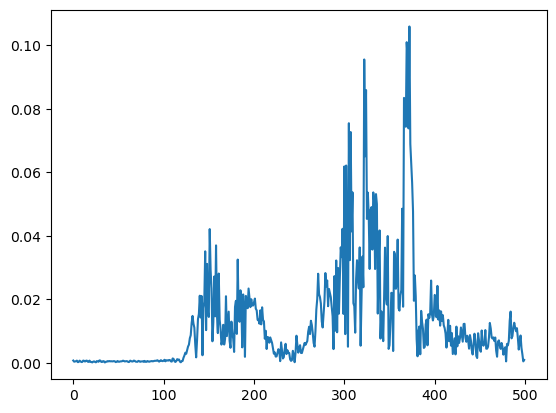

In [39]:
plt.plot(sample)
plt.show()

In [43]:
tn_model = tn_models[0][2].to(device)
out = tn_model(embedding(sample.unsqueeze(0).to(device))).pow(2)
out / out.sum()

tensor([[0.2789, 0.7211]], device='cuda:0', grad_fn=<DivBackward0>)

In [40]:
tn_model = tn_models[0][2].to(device)
in_features = tn_model.in_features[:]
out_position = tn_model.out_position

mats = []

for feat in in_features:
    tn_model.unset_data_nodes()
    tn_model.out_features = [feat, out_position]
    
    if feat < out_position:
        aux_sample = torch.cat([sample[:feat], sample[(feat + 1):]], dim=0)
    else:
        aux_sample = torch.cat([sample[:(feat - 1)], sample[feat:]], dim=0)
    
    tn_model.trace(torch.zeros(1, 499, 2).to(device),
                   inline_input=False,
                   inline_mats=False)
    
    result = tn_model(embedding(aux_sample.unsqueeze(0).to(device)),
                      inline_input=False,
                      inline_mats=False).squeeze(0)
    
    # feat x out
    if feat < out_position:
        mats.append(result)
    else:
        mats.append(result.t())

tn_model.unset_data_nodes()
tn_model.out_features = [out_position]
tn_model.reset()

In [209]:
# General relevance
relevance = []

domain_multiplier = 10
domain = torch.arange(domain_multiplier * phys_dim).float() / \
    (domain_multiplier * phys_dim)

discretization = embedding(domain).to(device)

for m in mats:
    cond_distr = (discretization @ m).pow(2)
    cond_distr = cond_distr / cond_distr.sum(dim=1, keepdim=True)
    
    cond_distr = torch.where(cond_distr == 0, 1., cond_distr)
    entropy = -(cond_distr * cond_distr.log()).sum(dim=1)
    
    relevance.append(entropy.cpu())

In [64]:
# Relevance for class 0
relevance0 = []

domain_multiplier = 5
domain = torch.arange(domain_multiplier * phys_dim).float() / \
    (domain_multiplier * phys_dim)

discretization = embedding(domain).to(device)

for m in mats:
    cond_distr = (discretization @ m[:, 0]).pow(2)
    cond_distr = cond_distr / cond_distr.sum()
    
    cond_distr = cond_distr[cond_distr > 0]
    entropy = -(cond_distr * cond_distr.log()).sum()
    
    relevance0.append(entropy.cpu())

relevance0 = torch.tensor(relevance0).pow(-1)

In [65]:
# Relevance for class 1
relevance1 = []

domain_multiplier = 5
domain = torch.arange(domain_multiplier * phys_dim).float() / \
    (domain_multiplier * phys_dim)

discretization = embedding(domain).to(device)

for m in mats:
    cond_distr = (discretization @ m[:, 1]).pow(2)
    cond_distr = cond_distr / cond_distr.sum()
    
    cond_distr = cond_distr[cond_distr > 0]
    entropy = -(cond_distr * cond_distr.log()).sum()
    
    relevance1.append(entropy.cpu())

relevance1 = torch.tensor(relevance1).pow(-1)

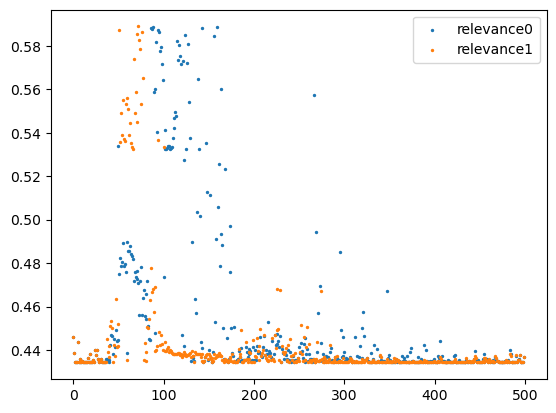

In [66]:
plt.scatter(range(len(relevance0)), relevance0, s=2)
plt.scatter(range(len(relevance1)), relevance1, s=2)
plt.legend(['relevance0', 'relevance1'])
plt.show()

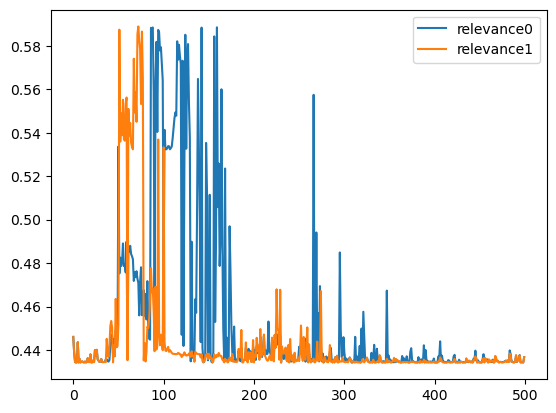

In [67]:
plt.plot(relevance0)
plt.plot(relevance1)
plt.legend(['relevance0', 'relevance1'])
plt.show()

The greater the entropy, the more irrelevant is that feature.

There is no important difference between relevance of features.

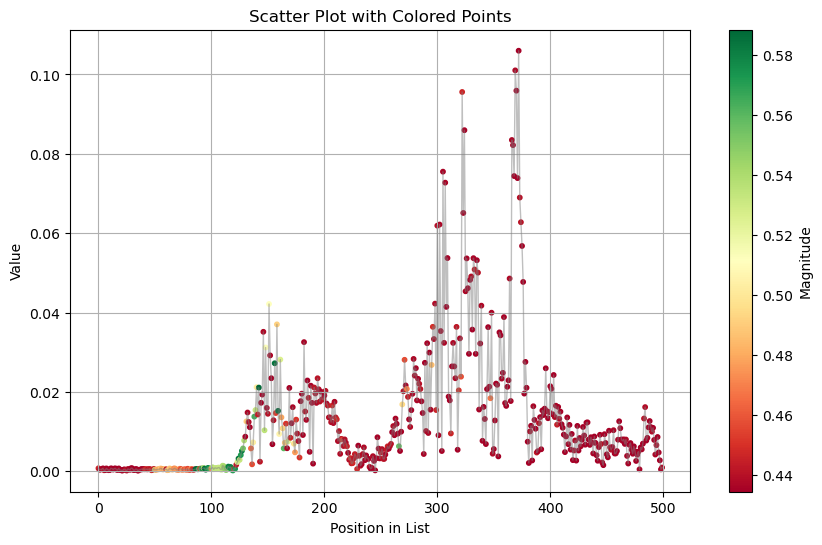

In [68]:
points = sample
values = relevance0

# Normalize the values for the color map
norm = plt.Normalize(values.min(), values.max())

# Create a colormap that goes from red to green
cmap = plt.cm.RdYlGn

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.plot(list(range(500)), points, color='grey', alpha=0.5, linewidth=1)
scatter = plt.scatter(list(range(500)), points, c=values, cmap=cmap, norm=norm, s=10)
plt.colorbar(scatter, label='Magnitude')  # Add colorbar to show the mapping
plt.title('Scatter Plot with Colored Points')
plt.xlabel('Position in List')
plt.ylabel('Value')
plt.grid(True)
plt.show()

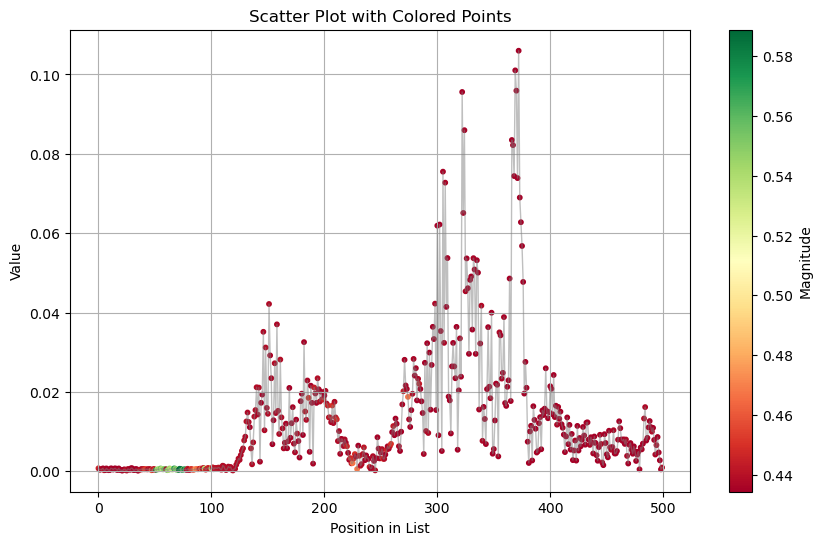

In [69]:
points = sample
values = relevance1

# Normalize the values for the color map
norm = plt.Normalize(values.min(), values.max())

# Create a colormap that goes from red to green
cmap = plt.cm.RdYlGn

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.plot(list(range(500)), points, color='grey', alpha=0.5, linewidth=1)
scatter = plt.scatter(list(range(500)), points, c=values, cmap=cmap, norm=norm, s=10)
plt.colorbar(scatter, label='Magnitude')  # Add colorbar to show the mapping
plt.title('Scatter Plot with Colored Points')
plt.xlabel('Position in List')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [94]:
tn_model = tn_models[0][2].to(device)
tn_model_lrp = cp.attr.LRP(tn_model)

relevance0 = tn_model_lrp.attribute(embedding(sample.unsqueeze(0).to(device)),
                                    target=0).detach().cpu()[0][:, 1]
relevance1 = tn_model_lrp.attribute(embedding(sample.unsqueeze(0).to(device)),
                                    target=1).detach().cpu()[0][:, 1]

/home/jose/anaconda3/envs/obfuscation/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [95]:
tn_model(embedding(sample.unsqueeze(0).to(device)))

tensor([[0.3833, 0.6163]], device='cuda:0', grad_fn=<ViewBackward0>)

In [96]:
relevance0.shape

torch.Size([500])

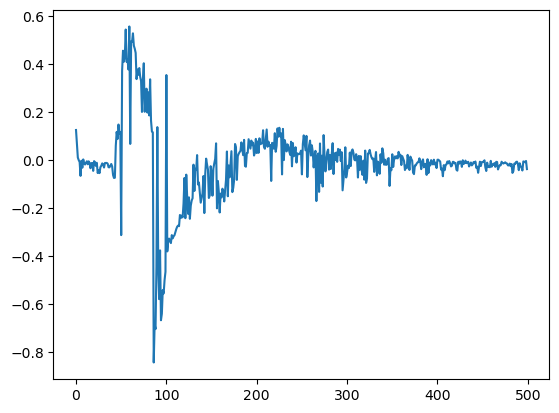

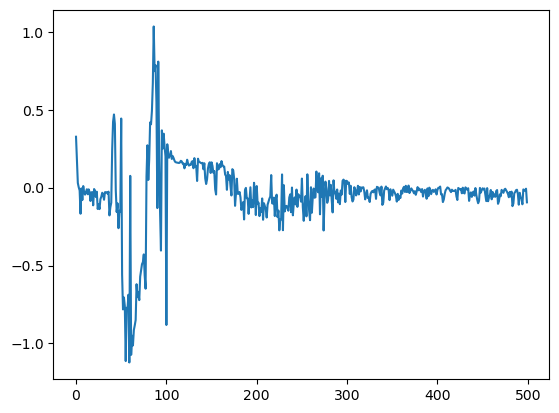

In [97]:
plt.plot(relevance0)
plt.show()

plt.plot(relevance1)
plt.show()

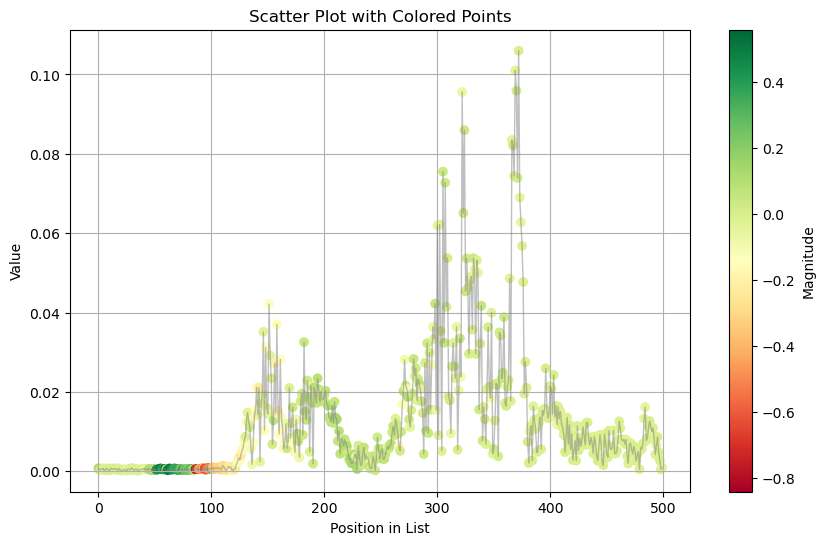

In [98]:
points = sample
values = relevance0

# Normalize the values for the color map
norm = plt.Normalize(values.min(), values.max())

# Create a colormap that goes from red to green
cmap = plt.cm.RdYlGn

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.plot(list(range(500)), points, color='grey', alpha=0.5, linewidth=1)
scatter = plt.scatter(list(range(500)), points, c=values, cmap=cmap, norm=norm)
plt.colorbar(scatter, label='Magnitude')  # Add colorbar to show the mapping
plt.title('Scatter Plot with Colored Points')
plt.xlabel('Position in List')
plt.ylabel('Value')
plt.grid(True)
plt.show()

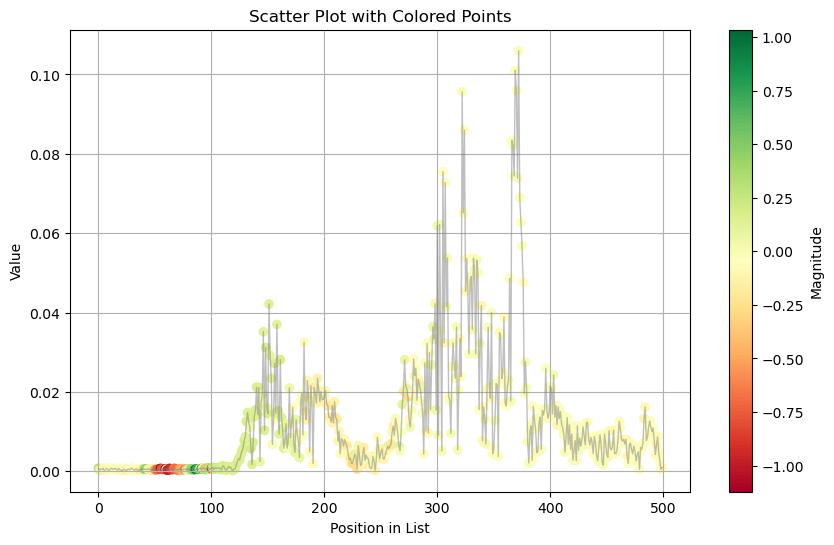

In [99]:
points = sample
values = relevance1

# Normalize the values for the color map
norm = plt.Normalize(values.min(), values.max())

# Create a colormap that goes from red to green
cmap = plt.cm.RdYlGn

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.plot(list(range(500)), points, color='grey', alpha=0.5, linewidth=1)
scatter = plt.scatter(list(range(500)), points, c=values, cmap=cmap, norm=norm)
plt.colorbar(scatter, label='Magnitude')  # Add colorbar to show the mapping
plt.title('Scatter Plot with Colored Points')
plt.xlabel('Position in List')
plt.ylabel('Value')
plt.grid(True)
plt.show()

### Integrated Gradients

In [ ]:
tn_model = tn_models[0][2].to(device)
tn_model_lrp = cp.attr.LRP(tn_model)

relevance0 = tn_model_lrp.attribute(embedding(sample.unsqueeze(0).to(device)),
                                    target=0).detach().cpu()[0][:, 0]
relevance1 = tn_model_lrp.attribute(embedding(sample.unsqueeze(0).to(device)),
                                    target=1).detach().cpu()[0][:, 1]

In [88]:
tn_model = tn_models[0][2].to(device)
tn_model_lrp = cp.attr.IntegratedGradients(tn_model)

igradients0 = tn_model_lrp.attribute(embedding(sample.unsqueeze(0).to(device)),
                                     embedding(torch.zeros(1, 500, device=device)),
                                     0).detach().cpu()[0][:, 1]
igradients1 = tn_model_lrp.attribute(embedding(sample.unsqueeze(0).to(device)),
                                     embedding(torch.zeros(1, 500, device=device)),
                                     1).detach().cpu()[0][:, 1]

In [89]:
tn_model(embedding(sample.unsqueeze(0).to(device)))

tensor([[0.3833, 0.6163]], device='cuda:0', grad_fn=<ViewBackward0>)

In [90]:
igradients0.sum(), igradients1.sum()

(tensor(-0.3789, dtype=torch.float64), tensor(-0.1842, dtype=torch.float64))

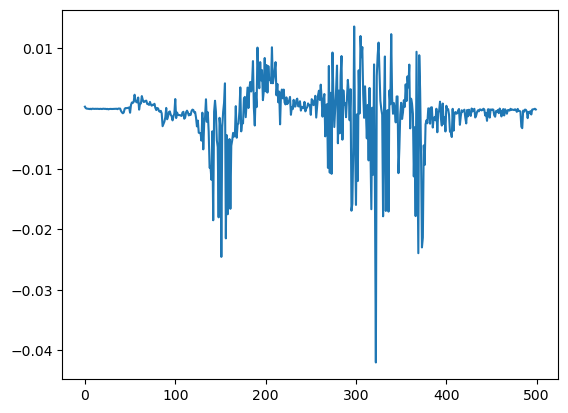

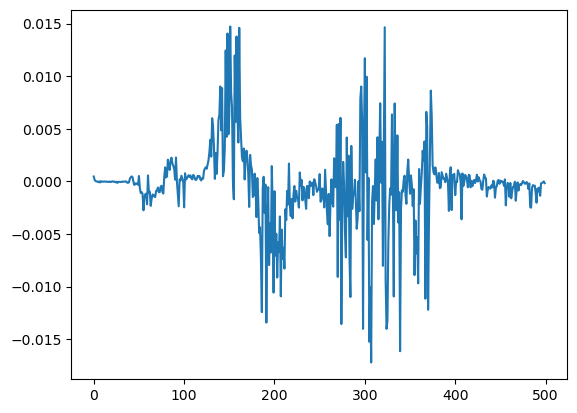

In [91]:
plt.plot(igradients0)
plt.show()

plt.plot(igradients1)
plt.show()

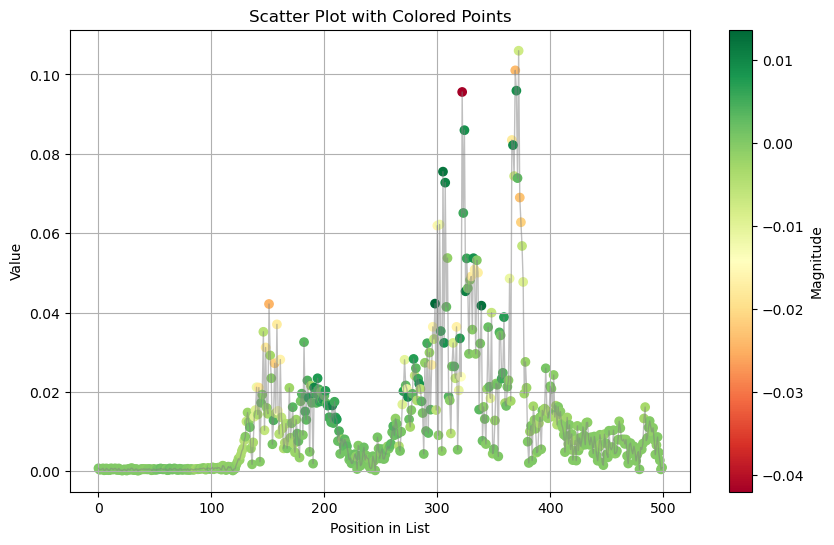

In [92]:
points = sample
values = igradients0

# Normalize the values for the color map
norm = plt.Normalize(values.min(), values.max())

# Create a colormap that goes from red to green
cmap = plt.cm.RdYlGn

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.plot(list(range(500)), points, color='grey', alpha=0.5, linewidth=1)
scatter = plt.scatter(list(range(500)), points, c=values, cmap=cmap, norm=norm)
plt.colorbar(scatter, label='Magnitude')  # Add colorbar to show the mapping
plt.title('Scatter Plot with Colored Points')
plt.xlabel('Position in List')
plt.ylabel('Value')
plt.grid(True)
plt.show()

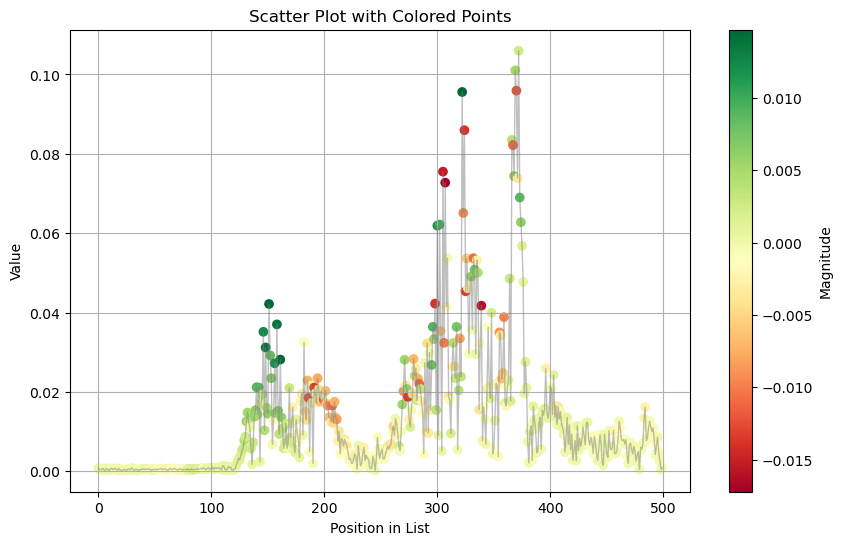

In [93]:
points = sample
values = igradients1

# Normalize the values for the color map
norm = plt.Normalize(values.min(), values.max())

# Create a colormap that goes from red to green
cmap = plt.cm.RdYlGn

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.plot(list(range(500)), points, color='grey', alpha=0.5, linewidth=1)
scatter = plt.scatter(list(range(500)), points, c=values, cmap=cmap, norm=norm)
plt.colorbar(scatter, label='Magnitude')  # Add colorbar to show the mapping
plt.title('Scatter Plot with Colored Points')
plt.xlabel('Position in List')
plt.ylabel('Value')
plt.grid(True)
plt.show()